In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_msssim
from tqdm import tqdm
from PIL import Image

sys.path.append("../")
import utils.data as data
import utils.graphics as graphics
import utils.loss as loss
import models

In [2]:
seed = 42
np.random.seed(seed)
_ = torch.manual_seed(seed)

In [264]:
batch_size = 64
num_dataloader_workers = 0

experiment_name = f"vq_vae_v5.16"

num_layers = 2
num_embeddings = 512
embedding_dim = 64
commitment_cost = 0.25
use_max_filters = True
max_filters = 512
image_size = 64
use_noise_images = True
small_conv = True  # To use the 1x1 convolution layer
encoding_dim = image_size // (2 ** num_layers)

data_folder = "..\\data\\Pokemon\\original_data"

output_dir = f"..\\outputs\\{experiment_name}"
model_path = os.path.join(output_dir, "model.pt")

In [265]:
# Setup Device
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")
print(gpu, device)

# Create Output Paths
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

False cpu


# Load Model

In [266]:
model = models.VQVAE(
    num_layers=num_layers,
    input_image_dimensions=image_size,
    small_conv=small_conv,
    embedding_dim=embedding_dim,
    num_embeddings=num_embeddings,
    commitment_cost=commitment_cost,
    use_max_filters=use_max_filters,
    max_filters=max_filters,
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
model.to(device)

VQVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (vq_vae): VectorQuantizerEMA(
    (_embedding): Embedding(512, 64)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, 

# Load Data

In [267]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_directory, transform):
        self.dataset_path = dataset_directory
        self.all_images = os.listdir(dataset_directory)
        self.transform = transform

    def __getitem__(self, index):
        filename = self.all_images[index]
        image_path = os.path.join(self.dataset_path, filename)
        image = Image.open(image_path).convert("RGBA")
        background = Image.new("RGBA", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
        fusion = self.transform(image)
        return filename, fusion

    def __len__(self):
        return len(self.all_images)

In [268]:
transform = data.image2tensor_resize(image_size)
dataset = CustomDataset(data_folder, transform)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_dataloader_workers,
    pin_memory=gpu,
)

In [269]:
def image_from_array(image, model_output=False):
    if model_output:
        image = image.detach().squeeze(0)
    plt.imshow(image.permute(1, 2, 0).numpy())

In [270]:
target_shape = (1, encoding_dim, encoding_dim, embedding_dim,)

# Get Encoding Mapping

In [271]:
num_encodings = encoding_dim ** 2
mapping_size = image_size // encoding_dim
encodings_mapping = {}
for i in range(num_embeddings):
    image = torch.tensor([i] * num_encodings).unsqueeze(1)
    model_output = model.quantize_and_decode(image, target_shape, device).permute(0, 2, 3, 1)[0].detach()
    model_output = model_output[0:mapping_size, 0:mapping_size]
    encodings_mapping[i] = model_output

In [272]:
encodings_mapping[0]

tensor([[[0.3958, 0.5501, 0.7217],
         [0.3938, 0.5406, 0.7250],
         [0.3830, 0.5310, 0.7262],
         [0.3887, 0.5494, 0.7390]],

        [[0.3908, 0.5342, 0.7269],
         [0.4040, 0.5600, 0.7414],
         [0.3996, 0.5554, 0.7477],
         [0.3795, 0.5328, 0.7252]],

        [[0.3355, 0.4689, 0.6303],
         [0.3535, 0.4800, 0.6509],
         [0.3475, 0.4801, 0.6530],
         [0.3250, 0.4582, 0.6067]],

        [[0.1398, 0.1947, 0.2464],
         [0.1301, 0.1703, 0.2148],
         [0.1249, 0.1634, 0.2040],
         [0.1491, 0.1917, 0.2415]]])

# Sample 1 Image

In [273]:
def encodings_to_image(encodings, mappings, image_size, mapping_size):
    image = torch.zeros(image_size, image_size, 3)
    j = 0
    for i, encoding in enumerate(encodings):
        encoding = mappings[encoding.item()]
        row_min = (i * mapping_size) % image_size
        row_max = row_min + mapping_size
        col_min = j * mapping_size
        col_max = col_min + mapping_size
        image[col_min:col_max, row_min:row_max] = encoding
        if row_max == image_size:
            j += 1
    return image

In [274]:
for _, x in dataloader:
    break
x = x[0].unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


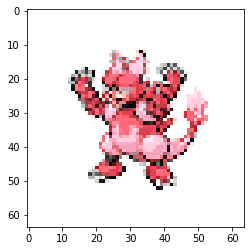

In [275]:
image_from_array(x[0])

In [276]:
encodings = model(x)[3].detach()

In [277]:
%%timeit
image = encodings_to_image(encodings, encodings_mapping, image_size, mapping_size)
# plt.imshow(image)

2.35 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [278]:
%%timeit
image = model.quantize_and_decode(encodings, target_shape, device)
# image_from_array(image, True)

13.1 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Observations:
The decoder is faster in cases where we have a lot of encodings E.G. 1024 or 4096. But in cases with a smaller number of embeddings (256, 64), the non-decoder approach is faster.